In [1]:
# store login data in login.py
%run login.py

# login query as multiline formatted string
# this assumes that login and pwd are defined 
# above

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""

import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})
mylogin

token = mylogin.json()['data']['logIn']['jwt']['token']

In [2]:
# Devices
query1 = """
query {
  devices {
    count
    edges {
      node {
        rawId
        name
        serialno
      }
    }
  }
}
"""

devices = requests.post(url, json={'query': query1}, headers = {'Authorization':token})

devices.json()

{'data': {'devices': {'count': 3,
   'edges': [{'node': {'name': 'Streetscape - Sandbox',
      'rawId': '1b41b3eb5c254ea188c5bba172a89f76',
      'serialno': 'SWLSANDBOX1'}},
    {'node': {'name': 'Outside - Sandbox',
      'rawId': '29b315c428c54c77833d10822b429ded',
      'serialno': 'SWLSANDBOX3'}},
    {'node': {'name': 'Under Raincoat - Sandbox',
      'rawId': 'b0e5945bb2b14ad5977b138cd534c42e',
      'serialno': 'SWLSANDBOX2'}}]}}}

In [3]:
# Counts
query2 = """
query {
  feedCountMetrics(
    serialnos:["SWLSANDBOX1"],
    startTime:"2019-12-01T00:00:00",
    endTime:"2020-12-31T00:00:00",
    objClasses:["pedestrian"],
    timezone:"America/New_York",
    interval:"24h") {
    edges {
      node {
        serialno
        result
        objClass
        time
      }
    }
  }
}
"""

dec2019peds = requests.post(url, json={'query': query2}, headers = {'Authorization':token})

import json

print(json.dumps(dec2019peds.json()['data']['feedCountMetrics']['edges'][0], indent = 1))

{
 "node": {
  "objClass": "pedestrian",
  "result": 1.0,
  "serialno": "SWLSANDBOX1",
  "time": "2019-12-01T00:00:00-05:00"
 }
}


In [4]:
# Heatmaps
query3 = """
query {
  feedHeatmaps(
    serialno: "SWLSANDBOX1",
    startTime:"2019-11-03T00:00:00",
    endTime:"2019-12-31T00:00:00",
    objClasses:["pedestrian"],
    timezone:"America/New_York") {
    edges {
      node {
        time
        objClass
        heatmap
      }
    }
  }
}
"""

dec2019heat = requests.post(url, json={'query': query3}, headers = {'Authorization':token})

dec2019heat.json()['data']['feedHeatmaps']['edges'][0]['node']['heatmap'][0:3]

[[491, 40, 0.18], [492, 40, 0.18], [493, 40, 0.18]]

In [5]:
import seaborn as sns
import pandas as pd

In [6]:
df = pd.DataFrame(dec2019heat.json()['data']['feedHeatmaps']['edges'][0]['node']['heatmap'])

In [7]:
import numpy as np
arr = np.zeros((480,640))

In [8]:
for point in dec2019heat.json()['data']['feedHeatmaps']['edges'][0]['node']['heatmap']:
    arr[point[1]][point[0]] = point[2]

In [9]:
import matplotlib.pyplot as plt


In [10]:
import numpy as np

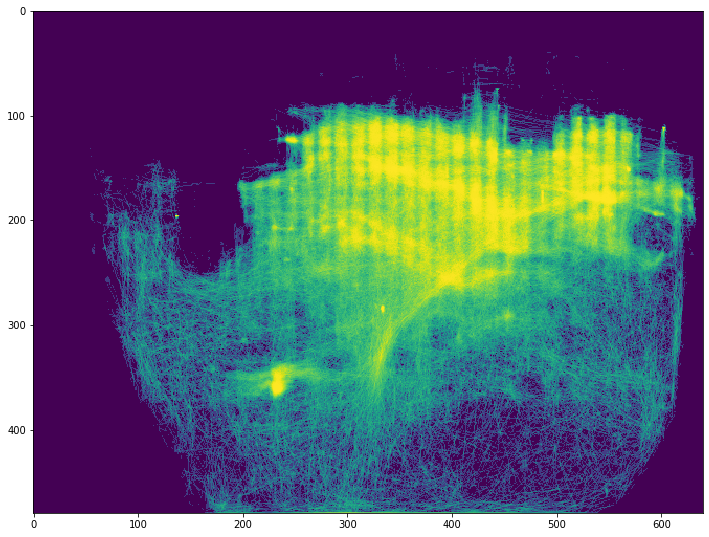

In [11]:
plt.figure(figsize = (12,16))
plt.imshow(arr)
plt.show()

In [12]:
from scipy import ndimage

In [13]:
blurred = ndimage.gaussian_filter1d(arr, 2, axis=1)
blurred = ndimage.gaussian_filter(blurred, 5)

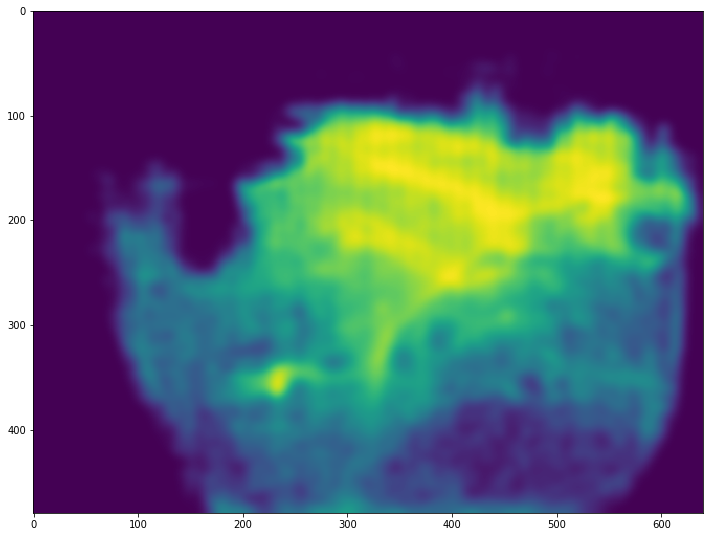

In [14]:
plt.figure(figsize = (12,16))
plt.imshow(blurred)
plt.show()

In [15]:
gx, gy = np.gradient(blurred)

In [16]:
Y  = np.arange(480)[::-1]
X = np.arange(640)

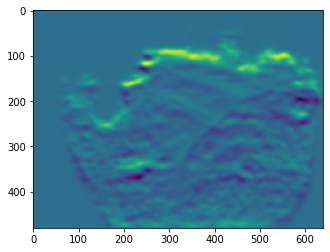

In [17]:
plt.imshow(gx)

In [18]:
skip=(slice(None,None,5),slice(None,None,5))

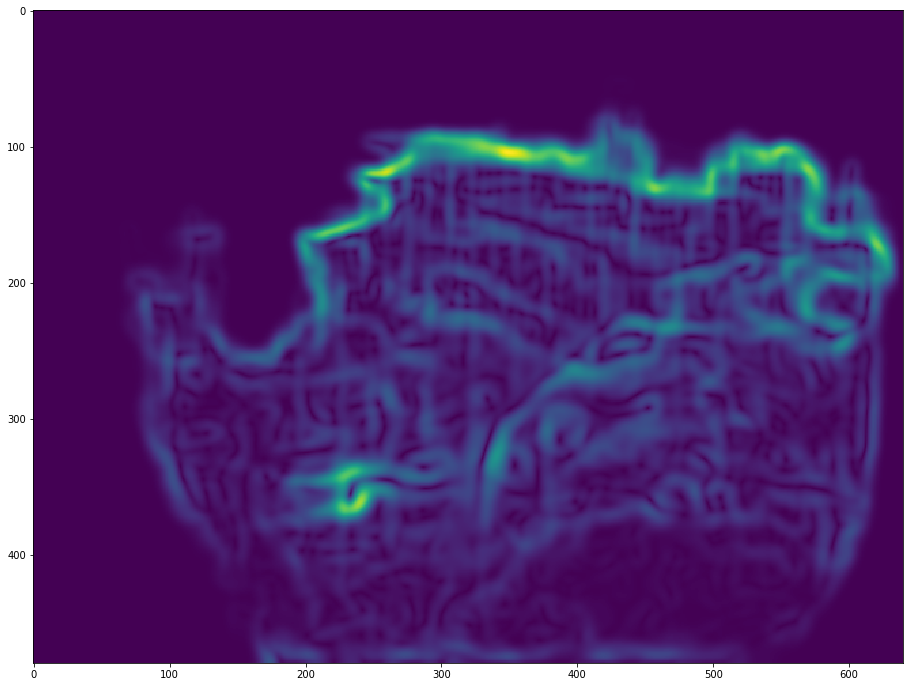

In [19]:
color = np.sqrt(gx**2 + gy**2) 
max_c = np.max(color)

color = color / max_c

plt.figure(figsize = (16,12))
plt.imshow(color * blurred)

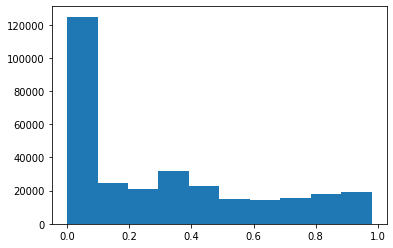

In [20]:
plt.hist(blurred.flatten());

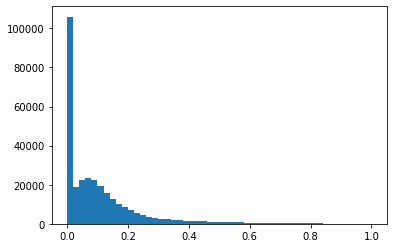

In [21]:
plt.hist(color.flatten(), bins=50);

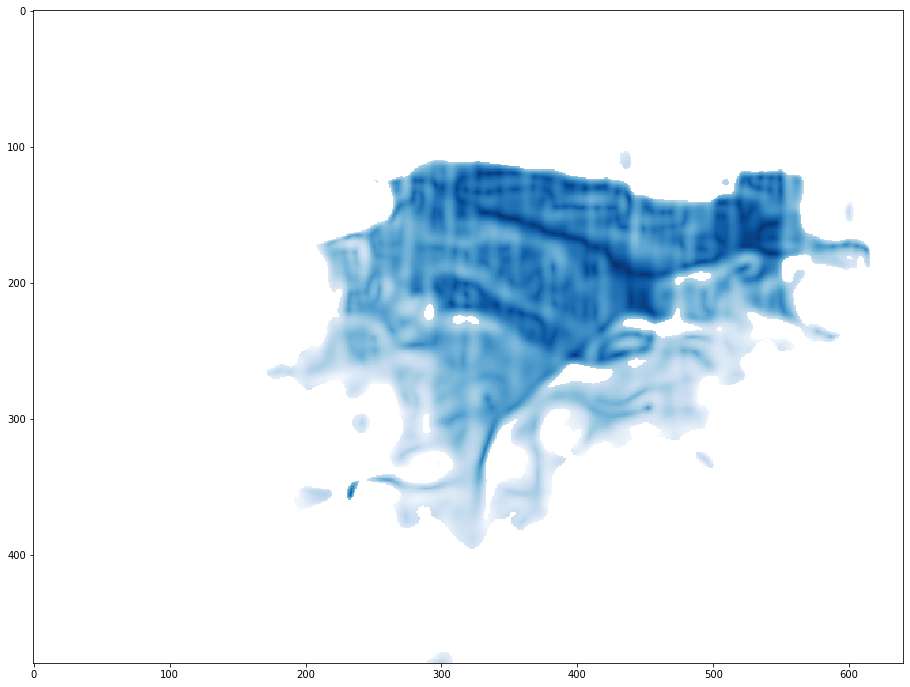

In [24]:
from matplotlib import cm

filter1 = np.where(blurred > 0.5, color, np.nan) # keep high density
filter2 = np.where(color < 0.2, filter1,np.nan) # keep low gradient
filter3 = (1 - filter2) ** 2 * blurred # highlighting high density and low gradient even more
plt.figure(figsize = (16,12))
plt.imshow(filter3, cmap=plt.get_cmap("Blues"))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


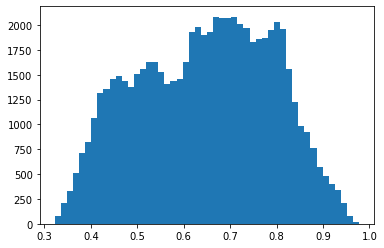

In [25]:
plt.hist(filter3.flatten(), bins=50);

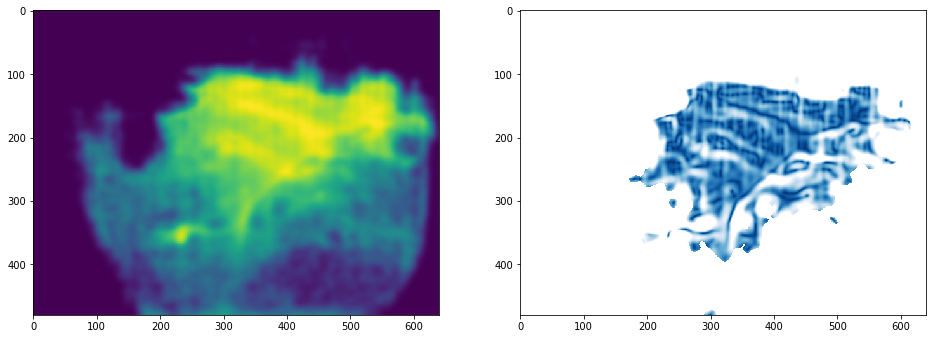

In [26]:
# high density areas with low gradient

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(blurred)
axs[1].imshow(filter2, cmap=plt.get_cmap("Blues_r"))


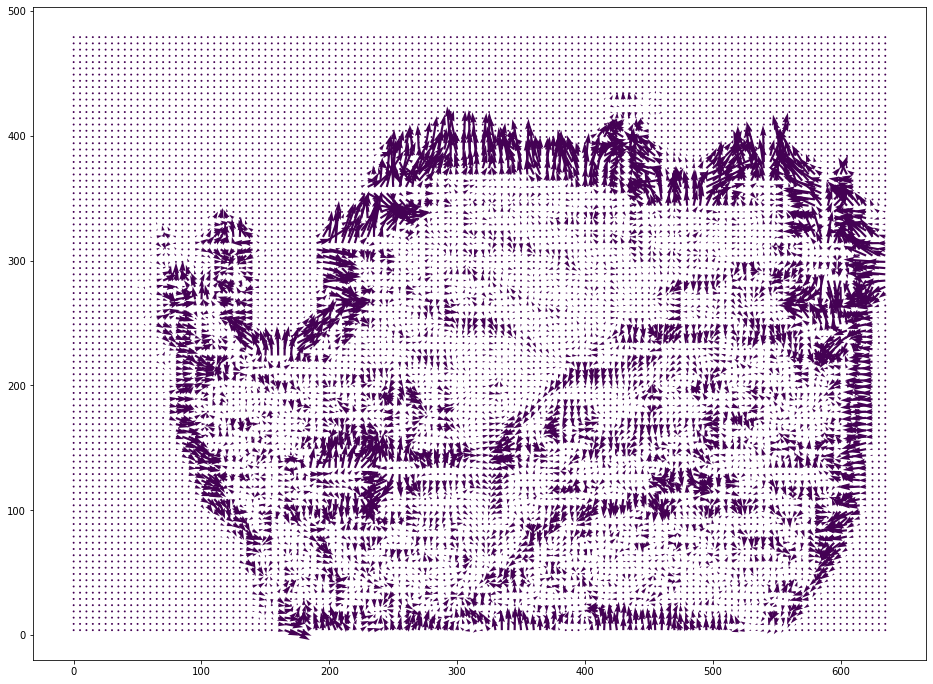

In [320]:
plt.figure(figsize = (16,12))
plt.quiver(X[::5], Y[::5], gy[skip], gx[skip], color)

In [164]:
import cv2

cv2.Canny(blurred,100,200)

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'Canny'
